### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, cv2, itertools
from keras.layers import Input, Dense, Dropout
from keras.models import Sequential, Model
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.utils import np_utils
import keras
import tensorflow as tf # add this if get attribute error
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


### Initialization

In [2]:
#Make sure do not have words "cat" or "dog" in path name
TRAIN_DIR = r'/Users/juwanenglish/CPE 4903 - NN/Cs_and_Ds/train'  
ROWS = 64
COLS = 64
CHANNELS = 3

In [3]:
train_images = [TRAIN_DIR+'//'+i for i in os.listdir(TRAIN_DIR)]
train_images[0:2]

['/Users/juwanenglish/CPE 4903 - NN/Cs_and_Ds/train//dog.8011.jpg',
 '/Users/juwanenglish/CPE 4903 - NN/Cs_and_Ds/train//cat.5077.jpg']

In [4]:
def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    return cv2.resize(img, (ROWS, COLS),interpolation=cv2.INTER_CUBIC)

In [5]:
def sigmoid(Z):
    a = 1/(1+np.exp(-z))
    return a

In [8]:
def data_prep(images): 
    m = len(images)

    X = np.ndarray((m,ROWS,COLS,CHANNELS), dtype = np.uint8)
    Y = np.zeros((m,1))
    print("X.shape is {}".format(X.shape))
   
    for i, image_file in enumerate(images) :
        image = read_image(image_file)
        X[i,:] = np.squeeze(image.reshape((ROWS, COLS, CHANNELS)))
        if 'cat' in image_file.lower() :
            Y[i,0] = 1
        elif 'dog' in image_file.lower():
            Y[i,0] = 0
        else :
            print('ERROR')
        

        if i%5000 == 0 :
            print("Iteration {} of {}".format(i,m))
            
    return X,Y

In [9]:
X,Y = data_prep(train_images)

X.shape is (25000, 64, 64, 3)
Iteration 0 of 25000
Iteration 5000 of 25000
Iteration 10000 of 25000
Iteration 15000 of 25000
Iteration 20000 of 25000


In [10]:
#X = X.reshape(25000,64,64,3)
#Y = Y.reshape(25000,1)

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
print('Shape of X_train is {}'.format(X_train.shape))
print('Shape of X_test is {}'.format(X_test.shape))
print('Shape of Y_train is {}'.format(Y_train.shape))
print('Shape of Y_test is {}'.format(Y_test.shape))

Shape of X_train is (20000, 64, 64, 3)
Shape of X_test is (5000, 64, 64, 3)
Shape of Y_train is (20000, 1)
Shape of Y_test is (5000, 1)


In [12]:
np.savez('train', X = X_train, Y = Y_train)
np.savez('test', X = X_test, Y = Y_test)

In [13]:
train_set = np.load('train.npz')
test_set = np.load('test.npz')
X_train = train_set['X']
Y_train = train_set['Y']
X_test = test_set['X']
Y_test = test_set['Y']

In [14]:
X_train = X_train/255
X_test = X_test/255

In [15]:
nb_classes = 2 # number of classification outputs cat or dog
Y_train = np_utils.to_categorical(Y_train, nb_classes)
Y_test = np_utils.to_categorical(Y_test, nb_classes)
print('Shape of Y_train is {}'.format(Y_train.shape))
print('Shape of Y_test is {}'.format(Y_test.shape))

Shape of Y_train is (20000, 2)
Shape of Y_test is (5000, 2)


In [24]:
model_cnn = Sequential()

model_cnn.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
model_cnn.add(MaxPooling2D(pool_size = (2,2)))
model_cnn.add(Dropout(0.2))

model_cnn.add(Conv2D(64, (3, 3), activation = 'relu'))
model_cnn.add(MaxPooling2D(pool_size = (2,2)))
model_cnn.add(Dropout(0.2))

model_cnn.add(Conv2D(128, (3, 3), activation = 'relu'))
model_cnn.add(MaxPooling2D(pool_size = (2,2)))
model_cnn.add(Dropout(0.2))

model_cnn.add(Conv2D(256, (3, 3), activation = 'relu'))
model_cnn.add(MaxPooling2D(pool_size = (2,2)))
model_cnn.add(Dropout(0.2))

model_cnn.add(Flatten())
model_cnn.add(Dense(units = 300, activation = 'relu'))
model_cnn.add(Dense(units = 2, activation = 'sigmoid'))

In [25]:
model_cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [26]:
print(model_cnn.summary())
history = model_cnn.fit(X_train,Y_train,epochs=30,batch_size=200,validation_split=.2,verbose=1)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 12, 12, 128)      

In [27]:
score = model_cnn.evaluate(X_test, Y_test, verbose=1)

5000/5000 [==============================] - 14s 3ms/step


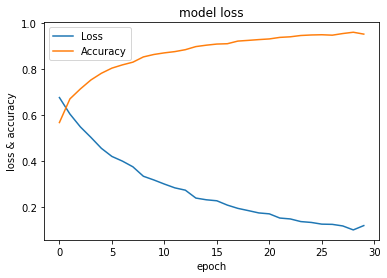

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.title('model loss')
plt.ylabel('loss & accuracy')
plt.xlabel('epoch')
plt.legend(['Loss','Accuracy']);

In [34]:
# Evaluate a different way
print('Evaluate on train data')
Yhat = model_cnn.predict(X_train)
acc = np.mean(np.rint(Yhat) == Y_train)
print('The train accuracy is:', acc*100)

Evaluate on train data
The train accuracy is: 90.3175


In [35]:
# Evaluate a different way
print('Evaluate on test data')
Yhat = model_cnn.predict(X_test)
acc = np.mean(np.rint(Yhat) == Y_test)
print('The test accuracy is:', acc*100)

Evaluate on test data
The test accuracy is: 80.76


### Test with pictures the model has never seen.

In [76]:
TEST_DIR = r'/Users/juwanenglish/CPE 4903 - NN/Cs_and_Ds/test'
test_images = [TEST_DIR+'/'+i for i in os.listdir(TEST_DIR)]
test_images[0]

'/Users/juwanenglish/CPE 4903 - NN/Cs_and_Ds/test/9733.jpg'

In [77]:
classes = {1: 'cats',
           0: 'dogs'}

File path /Users/juwanenglish/CPE 4903 - NN/Cs_and_Ds/test/1939.jpg
Prediction: DOG with probability [100]%


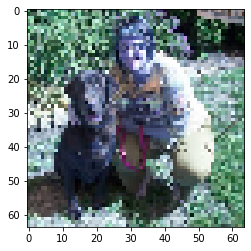

File path /Users/juwanenglish/CPE 4903 - NN/Cs_and_Ds/test/10859.jpg
Prediction: DOG with probability [100]%


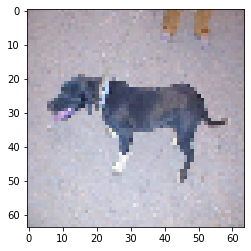

File path /Users/juwanenglish/CPE 4903 - NN/Cs_and_Ds/test/8882.jpg
Prediction: DOG with probability [100]%


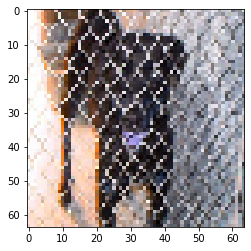

File path /Users/juwanenglish/CPE 4903 - NN/Cs_and_Ds/test/8465.jpg
Prediction: CAT with probability [100]%


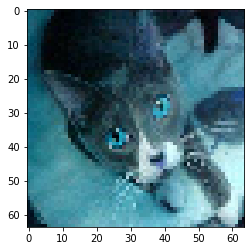

File path /Users/juwanenglish/CPE 4903 - NN/Cs_and_Ds/test/12019.jpg
Prediction: CAT with probability [100]%


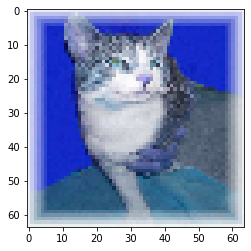

File path /Users/juwanenglish/CPE 4903 - NN/Cs_and_Ds/test/10864.jpg
Prediction: DOG with probability [100]%


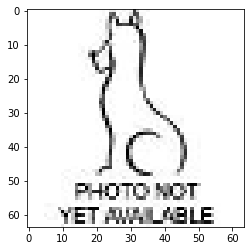

File path /Users/juwanenglish/CPE 4903 - NN/Cs_and_Ds/test/10753.jpg
Prediction: DOG with probability [100]%


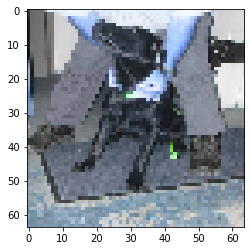

File path /Users/juwanenglish/CPE 4903 - NN/Cs_and_Ds/test/10647.jpg
Prediction: DOG with probability [100]%


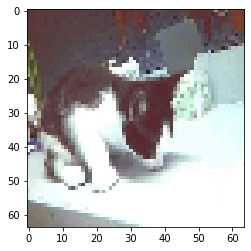

File path /Users/juwanenglish/CPE 4903 - NN/Cs_and_Ds/test/6359.jpg
Prediction: CAT with probability [100]%


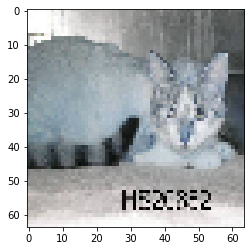

File path /Users/juwanenglish/CPE 4903 - NN/Cs_and_Ds/test/12244.jpg
Prediction: DOG with probability [100]%


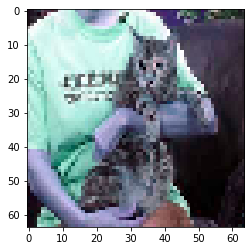

In [75]:
for i in np.random.randint(0, len(X_test), 10):
    test_image = read_image(test_images[i])
    print('File path',test_images[i])
    #print(test_image.shape)
    test_img = test_image.reshape(1, ROWS,COLS,CHANNELS)/255
    A = model_cnn.predict_classes(test_img)
    if A>.5:
        print('Prediction: CAT with probability {}%'. format(A*100))
    else:
        print('Prediction: DOG with probability {}%'. format(100-A*100))
    plt.imshow(test_image);
    plt.show()


## Insights

Overall, the model performed pretty well for how much it was trained. It may have begun to over train towrads the end. I say that because it reachwd a 90% training accuracy, but only an 80% test accuracy. I know that we are supposed to see some drop in accruacy between the two datasets, but 10% is a bit much. I maybe should've added another layer or two to help with mapping features. But overall, I'm impressed with how the model performed.

### Extra examples just written a different way

In [57]:
def show_image_prediction(X, idx, model) :
    image = X[idx].reshape(1,64,64,3)
    image_class = classes[model.predict_classes(image).item()]
    image = image.reshape((ROWS, COLS, CHANNELS))
    plt.figure(figsize = (4,2))
    plt.imshow(image)
    plt.title("Test {} : I think this is {}".format(idx, image_class))
    plt.show()

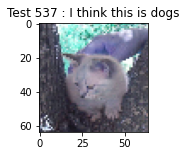

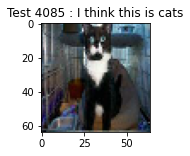

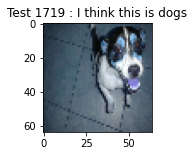

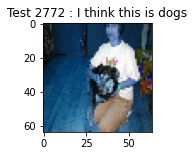

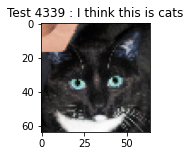

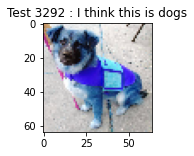

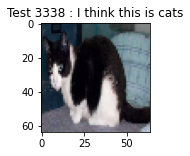

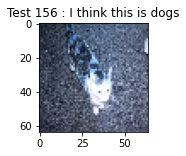

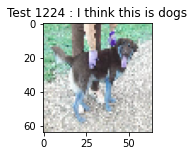

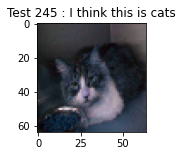

In [61]:
for i in np.random.randint(0, len(X_test), 10) :
    show_image_prediction(X_test, i, model_cnn)